In [1]:
%env OMP_NUM_THREADS=1
%env MKL_NUM_THREADS=4
%env OPENBLAS_NUM_THREADS=4
%matplotlib nbagg
from matplotlib import pyplot as plt
import numpy as np
import os
import glob
import sys

env: OMP_NUM_THREADS=1
env: MKL_NUM_THREADS=4
env: OPENBLAS_NUM_THREADS=4


In [2]:
 print(sys.version)

3.6.6 |Anaconda, Inc.| (default, Jun 28 2018, 17:14:51) 
[GCC 7.2.0]


In [3]:
sys.path.append('/usr/local/anaconda2/envs/libertem/lib/python3.6/site-packages/')

In [4]:
import hyperspy.api as hs

from libertem.executor.inline import InlineJobExecutor
from libertem.executor.dask import DaskJobExecutor
from libertem.api import Context
from libertem.io.dataset.dm import DMDataSet, DMFileSet, DMFile, DMFileSet, _get_offset

In [5]:
files = list(sorted(glob.glob("/cachedata/users/vadim/holo_time_series_01_Ltz_11_5K/*.dm4")))

In [6]:
ds = DMDataSet(files=files, stack=True)

In [7]:
%%time
ds = ds.initialize()

CPU times: user 1min 30s, sys: 1.85 s, total: 1min 32s
Wall time: 1min 46s


In [8]:
ds2 = DMDataSet(files=files[:100], stack=True)
ds2 = ds2.initialize()

In [9]:
#executor = DaskJobExecutor(client=)
#executor.make_local(client_kwargs={'n_workers' : 4})
sync_executor = DaskJobExecutor.make_local(client_kwargs={'n_workers' : 4})
ctx = Context(sync_executor)  # executor=InlineJobExecutor())

# Holo stuff

In [10]:
holo0 = hs.load(files[0], signal_type='hologram')
sb_pos = holo0.estimate_sideband_position()
sb_size = holo0.estimate_sideband_size(sb_pos).data
sb_pos = sb_pos.data
sb_smooth = 0.05
out_shape = 2* (int(2 * sb_size), )

In [11]:
sb_size

array([345.50832117])

In [12]:
np.mean((1, 3))

2.0

<IPython.core.display.Javascript object>


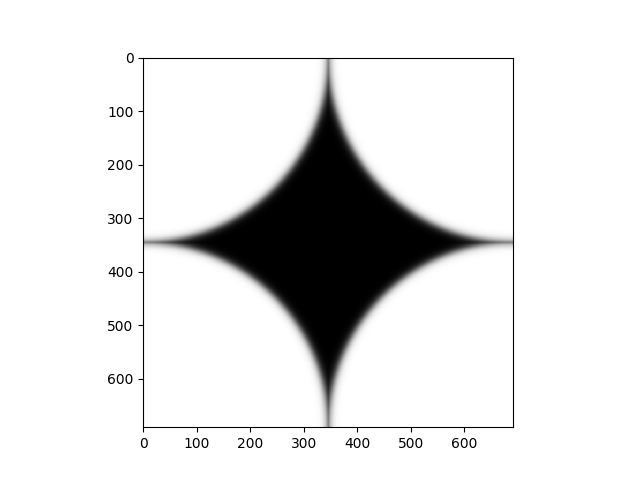

<IPython.core.display.Javascript object>


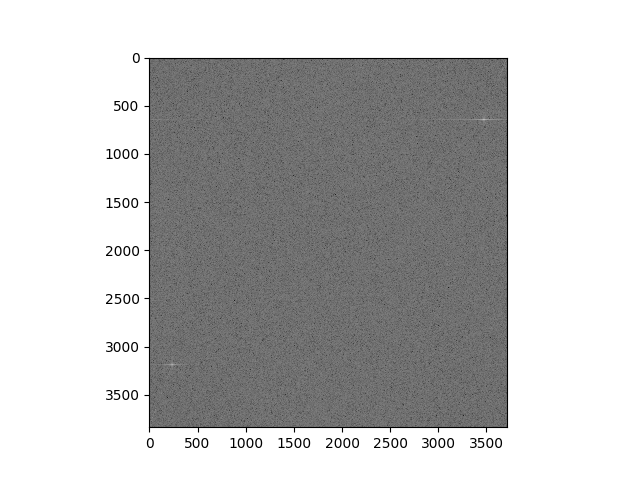

<IPython.core.display.Javascript object>


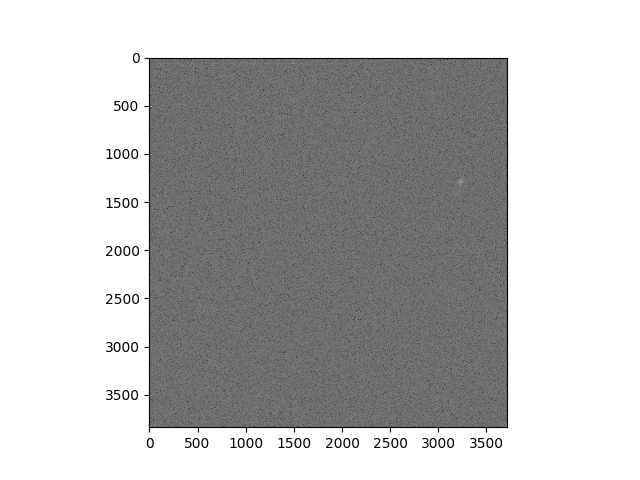

/Users/migunov/libertem_env/venv/lib/python3.6/site-packages/ipykernel_launcher.py:62: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


<IPython.core.display.Javascript object>


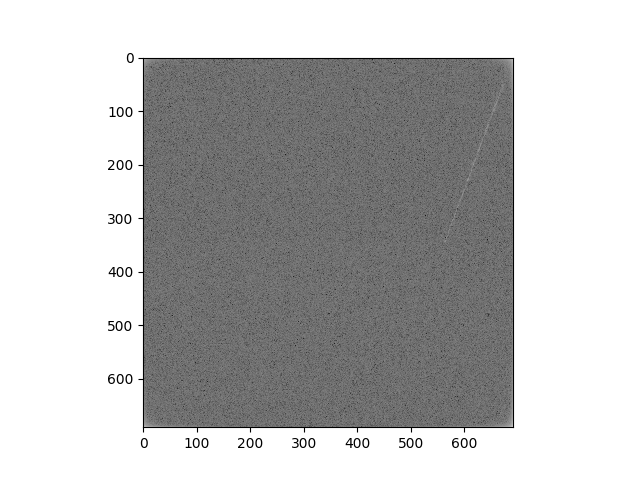

<IPython.core.display.Javascript object>


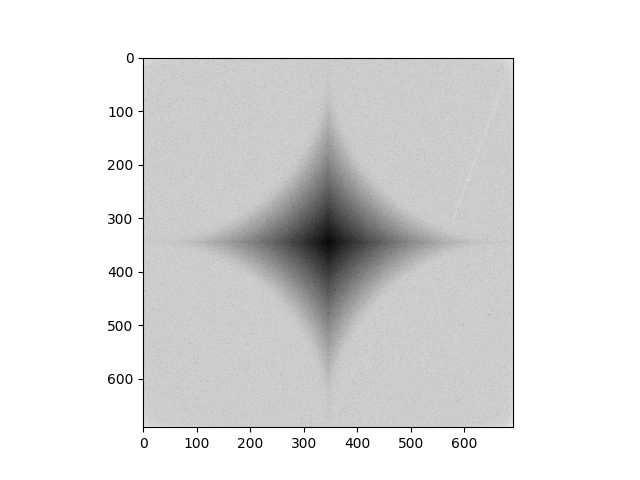

In [13]:
# Copyright 2007-2016 The HyperSpy developers
#
#  HyperSpy is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.
#
#  HyperSpy is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.
#
# You should have received a copy of the GNU General Public License
# along with  HyperSpy.  If not, see <http://www.gnu.org/licenses/>.
# 
# Copyright 2019 The LiberTEM developers
# 
#  LiberTEM is distributed under the terms of the GNU General 
# Public License as published by the Free Software Foundation,
# version 3 of the License.
# see: https://github.com/LiberTEM/LiberTEM



from libertem.udf import UDF
from hyperspy.misc.holography.reconstruct import freq_array, aperture_function
from mkl_fft import fft2, ifft2
from numpy.fft import fftshift

sy, sx = holo0.data.shape
oy, ox = out_shape
sb_smoothness = sb_size * sb_smooth

f_sampling = (1./oy, 1./ox)
f_freq = freq_array(out_shape, (1., 1.))

sb_size_new = sb_size * np.mean(f_sampling)
sb_smoothness_new = sb_smoothness * np.mean(f_sampling)

aperture = aperture_function(f_freq, sb_size_new, sb_smoothness_new)

plt.figure()
plt.imshow(aperture)

y_min = int(sy / 2 - oy / 2)
y_max = int(sy / 2 + oy / 2)
x_min = int(sx / 2 - ox / 2)
x_max = int(sx / 2 + oy / 2)
slice_fft = ([slice(y_min, y_max), slice(x_min, x_max)])

frame_size = holo0.data.shape

fft_frame = fft2(holo0.data) / np.prod(frame_size)
plt.figure()
plt.imshow(np.log(np.abs(fft_frame)))

fft_frame = np.roll(fft_frame, sb_pos[0], axis=0)
fft_frame = np.roll(fft_frame, sb_pos[1], axis=1)
plt.figure()
plt.imshow(np.log(np.abs(fft_frame)))

fft_frame = fftshift(fftshift(fft_frame)[slice_fft])
plt.figure()
plt.imshow(np.log(np.abs(fft_frame)))

fft_frame = fft_frame * aperture
plt.figure()
plt.imshow(np.log(np.abs(fft_frame)))

wav = ifft2(fft_frame) * np.prod(frame_size)

<IPython.core.display.Javascript object>


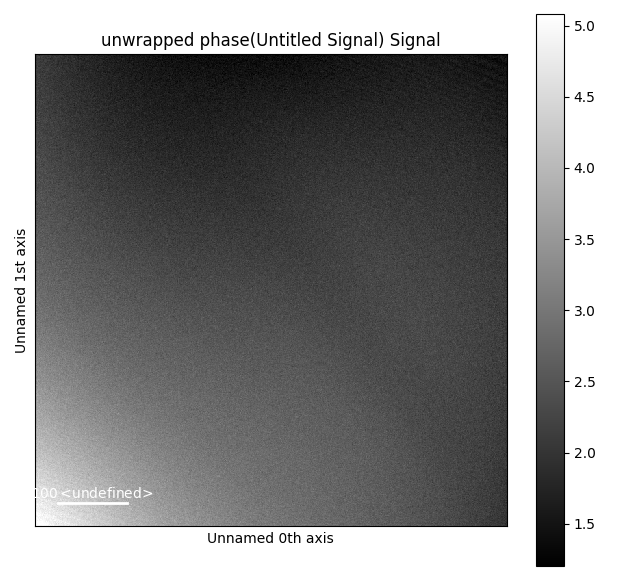

In [14]:
wav = hs.signals.ComplexSignal2D(wav)
wav.unwrapped_phase().plot()

<IPython.core.display.Javascript object>


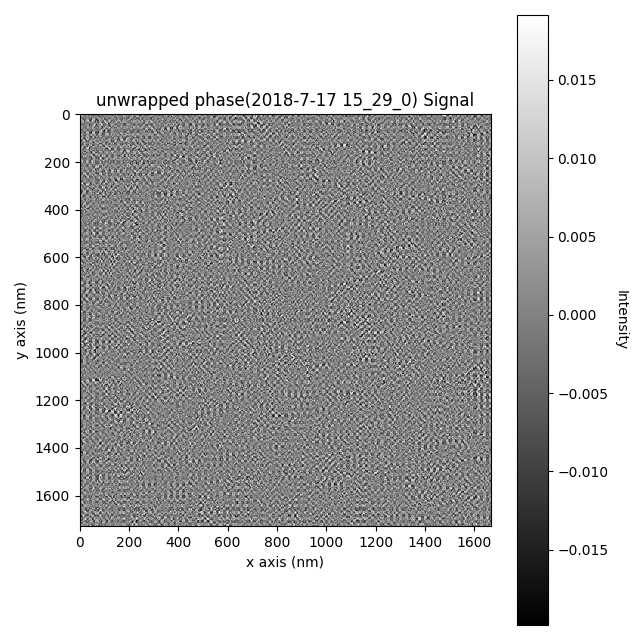

In [15]:
wav_hs = holo0.reconstruct_phase(output_shape=out_shape)
(wav_hs.unwrapped_phase() - wav.unwrapped_phase()).plot()

In [16]:
# Copyright 2007-2016 The HyperSpy developers
#
#  HyperSpy is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.
#
#  HyperSpy is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.
#
# You should have received a copy of the GNU General Public License
# along with  HyperSpy.  If not, see <http://www.gnu.org/licenses/>.
# 
# Copyright 2019 The LiberTEM developers
# 
#  LiberTEM is distributed under the terms of the GNU General 
# Public License as published by the Free Software Foundation,
# version 3 of the License.
# see: https://github.com/LiberTEM/LiberTEM

from libertem.udf import UDF
from hyperspy.misc.holography.reconstruct import freq_array, aperture_function
from mkl_fft import fft2, ifft2
from numpy.fft import fftshift

class HoloReconstructUDF(UDF):
    def get_result_buffers(self):
        extra_shape = self.params.out_shape
        return {
            "wave": self.buffer(kind="nav", dtype=np.complex128, extra_shape=extra_shape)
        }
    def get_task_data(self):
        out_shape = self.params.out_shape
        sy, sx = self.meta.partition_shape.sig
        oy, ox = out_shape
        f_sampling = (1./oy, 1./ox)
        sb_size = self.params.sb_size * np.mean(f_sampling)
        sb_smoothness = sb_size * self.params.sb_smoothness * np.mean(f_sampling)
        
        f_freq = freq_array(out_shape, (1., 1.))
        aperture = aperture_function(f_freq, sb_size, sb_smoothness)
        
        y_min = int(sy / 2 - oy / 2)
        y_max = int(sy / 2 + oy / 2)
        x_min = int(sx / 2 - ox / 2)
        x_max = int(sx / 2 + oy / 2)
        slice_fft = ([slice(y_min, y_max), slice(x_min, x_max)])
        
        kwargs = {
            'aperture': aperture,
            'slice' : slice_fft
        }
        return kwargs
        
    def process_frame(self, frame):
        # size_x, size_y = self.params.out_shape
        frame_size = self.meta.partition_shape.sig
        sb_pos = self.params.sb_position
        aperture = self.task_data.aperture
        slice_fft = self.task_data.slice
        
        fft_frame = fft2(frame) / np.prod(frame_size)
        fft_frame = np.roll(fft_frame, sb_pos[0], axis=0)
        fft_frame = np.roll(fft_frame, sb_pos[1], axis=1)
        
        fft_frame = fftshift(fftshift(fft_frame)[slice_fft])
        
        fft_frame = fft_frame * aperture

        wav = ifft2(fft_frame) * np.prod(frame_size)
        self.results.wave[:] = wav

In [17]:
%%time
udf = HoloReconstructUDF(out_shape=out_shape,
                         sb_position=sb_pos,
                         sb_size=sb_size,
                         sb_smoothness=sb_smooth)
res = ctx.run_udf(dataset=ds2, udf=udf)

CPU times: user 3.94 s, sys: 2.92 s, total: 6.86 s
Wall time: 28.3 s


In [18]:
wave = np.array(res['wave'])

In [19]:
wave.shape

(100, 691, 691)

In [20]:
wave = hs.signals.ComplexSignal2D(wave)

<IPython.core.display.Javascript object>


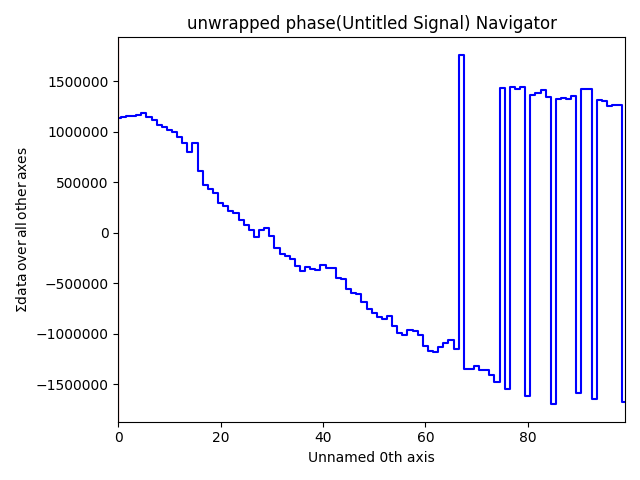

<IPython.core.display.Javascript object>


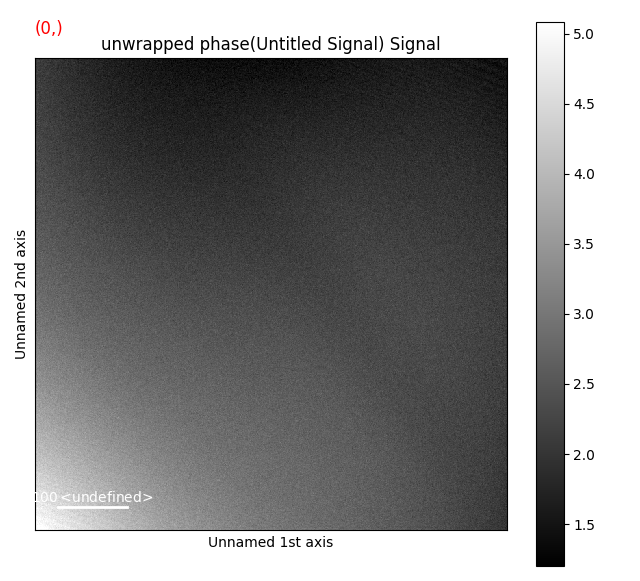

In [21]:
wave.unwrapped_phase().plot()

<IPython.core.display.Javascript object>


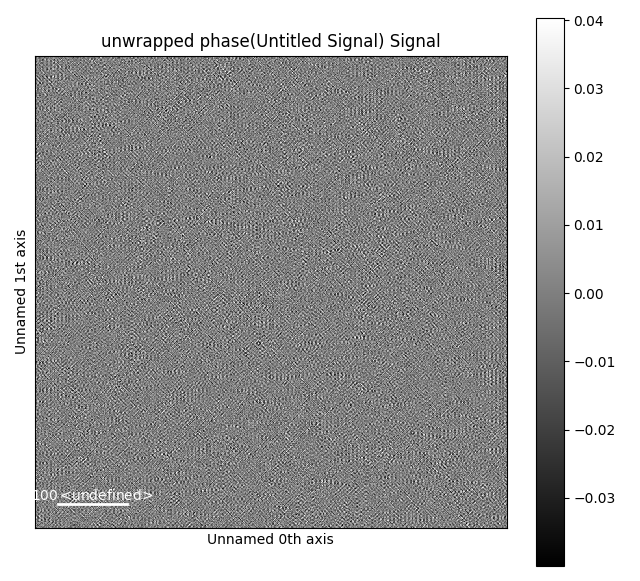

In [22]:
(wave.inav[0].unwrapped_phase() - wav_hs.unwrapped_phase()).plot()

In [23]:
del res, wave

In [24]:
%%time
udf = HoloReconstructUDF(out_shape=out_shape,
                         sb_position=sb_pos,
                         sb_size=sb_size,
                         sb_smoothness=sb_smooth)
res = ctx.run_udf(dataset=ds, udf=udf)

CPU times: user 6min, sys: 1min 14s, total: 7min 14s
Wall time: 9min 23s


In [25]:
wave = np.array(res['wave'])

In [26]:
wave.shape

(2651, 691, 691)